In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim as optim
from torch.autograd import Variable
import numpy.random as rand
import numpy as np
import sys
import os


from bnn import BNNBayesbyBackprop, gauss_logpdf
os.getcwd()

'/Users/d_berman/Documents/Tufts_Masters/Semester_3/Bayesian Deep Learning/BDL_final_project'

In [0]:
# Real dataset
#Emerson's Paths:
small_trained_path = "/content/drive/My Drive/Tufts/Tufts 19-20/Final Project: Get Churn't/data/smallTrainCleaned.csv"
y_label_path = "/content/drive/My Drive/Tufts/Tufts 19-20/Final Project: Get Churn't/data/y_labels.csv"
#small_trained_path = "/content/drive/My Drive/Tufts/Tufts '19-20/Fall 2019/Comp150-03 - Bayesian Deep Learning/Final Project: Get Churn't/data/smallTrainCleaned.csv"
#y_label_path = "/content/drive/My Drive/Tufts/Tufts '19-20/Fall 2019/Comp150-03 - Bayesian Deep Learning/Final Project: Get Churn't/data/y_labels.csv"
data = pd.read_csv(small_trained_path)
Y = pd.read_csv(y_label_path)

data['Y'] = Y
data['Y'][data['Y'] == -1] = 0
data = data.sample(frac=1).reset_index(drop=True)

print(Y)

In [0]:
batch_size = 100
n_iters = 3000

num_epochs = int(n_iters / (data.shape[0] / batch_size))

train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_dataset = data[:train_size]
test_dataset = data[train_size:]


train_y = train_dataset['Y']
train_dataset = train_dataset.drop('Y', axis=1)

test_y = test_dataset['Y']
test_dataset = test_dataset.drop('Y', axis=1)


train_loader = torch.utils.data.DataLoader(
                  torch.utils.data.TensorDataset(
                      torch.tensor(train_dataset.values),
                      torch.tensor(train_y.values)),
                  batch_size=batch_size,
                  shuffle=True)



test_loader = torch.utils.data.DataLoader(
                  torch.utils.data.TensorDataset(
                      torch.tensor(test_dataset.values),
                      torch.tensor(test_y.values)),
                  batch_size=batch_size,
                  shuffle=True)

NameError: ignored

In [0]:
# Toy dataset
X_path = "/content/drive/My Drive/Tufts/Tufts 19-20/Final Project: Get Churn't/data/toy_x.csv"
y_path = "/content/drive/My Drive/Tufts/Tufts 19-20/Final Project: Get Churn't/data/toy_y.csv"

X = np.loadtxt(X_path, delimiter=',', dtype=np.float64)[:1000]
y = np.loadtxt(y_path, delimiter=',', dtype=np.float64)[:1000]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, test_size=.2)


OSError: ignored

Toy dataset for regression

In [2]:
W = np.array([-10, 10]).reshape(-1, 1)
b = -5
X_train = np.random.uniform(-10,10, (5000, 2))
X_train[:,0] = 0.0
X_train.shape
W.T.shape

eps = 0.0001
W_s = np.array([0.0, 0.3]).reshape(-1, 1)
print(W_s)
b_s = 0.1

print(b_s)

y_train = np.zeros((X_train.shape[0], 1), dtype=float)
for ind, x in enumerate(X_train):
  # y_train[ind] = x @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
  y_train[ind] = x.reshape(1,-1) @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))



print(y_train)

[[0. ]
 [0.3]]
0.1
[[-17.94881003]
 [ 21.94888986]
 [-53.47660357]
 ...
 [-38.01600643]
 [ 43.67011704]
 [ 47.18211122]]


(array([628., 646., 592., 665., 621., 609., 672., 415., 128.,  24.]),
 array([-104.9880598 ,  -80.19734269,  -55.40662558,  -30.61590847,
          -5.82519135,   18.96552576,   43.75624287,   68.54695998,
          93.33767709,  118.1283942 ,  142.91911131]),
 <a list of 10 Patch objects>)

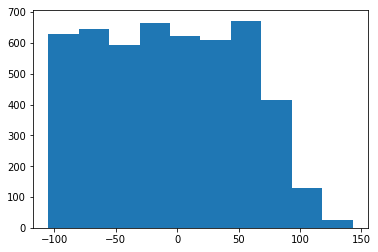

In [11]:
plt.hist(y_train)
# np.exp(10 * 0.01)

compare likelihood of test set given true mean and true variance and true variance + bias

In [5]:
tst = np.empty_like(X_train[:,0])
for ind, x in enumerate(X_train):
  # y_train[ind] = x @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
  tst[ind] = x.reshape(1,-1) @ W + b + np.random.normal(loc=0, scale=np.exp(x @ W_s + b_s))
tst

print(gauss_logpdf(tst, X_train @ W + b, np.exp(x @ W_s + b_s)).sum())
print(gauss_logpdf(tst, X_train @ W + b, np.exp(x @ W_s + b_s) + 100).sum())


-33145520362.758266
-31103853.933023214


In [2]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

print(y_train)
print(X_train)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(311, projection='3d')

sparse_cap = int(len(X_train) / 10)

ax.scatter(X_train[:,0], X_train[:,1], y_train)
ax.set_xlabel('X_train[:,0]')
ax.set_ylabel('X_train[:,1]')
ax.set_zlabel('output[:,1] (Standard Deviation)')


NameError: name 'y_train' is not defined

Toy dataset for classification

In [2]:
dataset_size = 5000

X_train = np.empty(shape=(dataset_size, 2), dtype=float)
y_train = np.empty(shape=(dataset_size,), dtype=float)

# make first dimension 0 to effectively make it univariate 
# bc current bnn arch only works with multivariate input
X_train[:,0] = 0 
X_train[:int(dataset_size/2), 1] = np.random.normal(loc=0.0, 
                                                    scale=1, 
                                                    size=(int(dataset_size/2),))
y_train[:int(dataset_size/2)] = 0

X_train[int(dataset_size/2):, 1] = np.random.normal(loc=4.0,
                                                    scale=1,
                                                    size=(int(dataset_size/2),))
y_train[int(dataset_size/2):] = 1

In [29]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

/anaconda3/envs/Pytorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9772

In [7]:
torch.empty(size=(10,))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [2]:
# y_train.reshape(-1)
# np.log(10)
# np.exp(-2.3)
# Maybe we want to plot epoch by mean and std weight values for linear regression model 
# as well as the true weights used to create the toy dataset?

# Seems like a good diagnostic plot which we could include in our report
# W_full = np.vstack((W_s.T, W.T))
W_full = np.hstack((W, W_s))
# W_full = np.hstack((W.T, W_s.T))
W_full
b_full = np.hstack((b, b_s))
b_full[1] = 2.0
bnn_preset = BNNBayesbyBackprop(prior_mu=0, prior_s=0.8, linear_regression=True, preset={'W_mu': W_full, 'b_mu': b_full})
preset_preds = bnn_preset.model.forward(torch.Tensor(X_train), predict=True).detach().numpy() 

# W_full
# W
# preset_preds.shape
print('MAE of BNN with q mean == true weights: ', np.mean(np.abs(preset_preds - y_train.flatten())))
# print(preset_preds[1], y_train[1])
# bnn_preset.model.l1.W_log_s_DO
# bnn_preset.model.l1.b_log_s_O
bnn_preset.MC_elbo(torch.Tensor(X_train), torch.Tensor(y_train), 9, 10, 100)

NameError: name 'W' is not defined

In [0]:
0.05 * -10 + -3.3 * 10 - 5

-38.5

In [73]:
# bnn = BNNBayesbyBackprop(prior_mu=0, prior_s=0.8, num_MC_samples=30, linear_regression=True, preset=False, classification=False)


bnn = BNNBayesbyBackprop(prior_mu=0, prior_s=0.8, num_MC_samples=30, linear_regression=True, preset=False, classification=True)
bnn.fit(X_train, y_train, plot=True, n_epochs=75, learning_rate=1.2e-2, batch_size=100)

continuous_pred:  [-0.3913737  -0.55910313 -0.42149815 -0.39059377 -0.34526765]
continuous_pred:  [-2.211674  -1.45712   -2.076155  -2.2151825 -2.4190884]
continuous_pred:  [-0.75848377 -0.42142418 -0.6979473  -0.760051   -0.85113585]
continuous_pred:  [-1.1643891  -0.28164518 -1.005847   -1.1684937  -1.4070408 ]
continuous_pred:  [-1.1900103 -1.0008004 -1.156028  -1.1908902 -1.2420211]
continuous_pred:  [-6.4309015 -3.1606965 -5.8435674 -6.4461074 -7.3298264]
continuous_pred:  [4.4308434 2.6291008 4.1072474 4.4392214 4.9261127]
continuous_pred:  [0.6764444  0.15825212 0.5833763  0.67885387 0.8188869 ]
continuous_pred:  [1.9561651 1.2331238 1.8263056 1.959527  2.154917 ]
continuous_pred:  [-4.245729  -1.7182766 -3.7917948 -4.257481  -4.9404836]
continuous_pred:  [-0.6967083   0.00835627 -0.57007766 -0.6999868  -0.8905189 ]
continuous_pred:  [4.630302  1.907242  4.1412363 4.642964  5.378826 ]
continuous_pred:  [4.6979294 2.1698403 4.2438803 4.7096844 5.3928595]
continuous_pred:  [3.2481

KeyboardInterrupt: 

In [63]:
bnn.likelihood_est(torch.tensor(y_train), torch.tensor(y_train), 0.1)

tensor(-2518.2195)

In [66]:
a = torch.normal(torch.tensor([0.0]*5), torch.tensor([5.0]*5))
print(a)

sig = nn.Sigmoid()
sig(a) > 0.5

bnn.likelihood_est(torch.tensor([0.0]*5), a, 0.1)

tensor([-5.4249, -3.5355, -6.5829, -0.8022, -2.1740])


tensor(-0.5219)

In [20]:


# Hyperparameters that work: prior_s 0.8
# Fix likelihood mean at 1?
bnn = BNNBayesbyBackprop(prior_mu=0, prior_s=0.8, linear_regression=True, preset=False)
bnn.fit(X_train, y_train, plot=True, n_epochs=75, learning_rate=5e-2, batch_size=100)

mean log prior  -5.82107666015625
mean log post est  -8.086301879882813
mean likelihood est  -2271.96375
grads  tensor([[ 2.8113e-02, -9.0588e-02],
        [ 6.3300e+03,  4.8646e-02]]) 

change in w1:  [ 0.00274605 -0.00090171] 
cur w1:  [0.0091938  0.21898751] 
old w1:  [0.00644776 0.21988922]
change in w2:  [0.00075768 0.00232763] 
cur w2:  [0.00281862 0.04392753] 
old w2:  [0.00206095 0.0415999 ]
change in b:  [ 0.00857747 -0.00893347] 
cur b:  [0.28585297 0.03298711] 
old b:  [0.2772755  0.04192058]
full weights: 
 [[0.0091938  0.00281862]
 [0.21898751 0.04392753]]
pred type:  <class 'torch.Tensor'>
Epoch:  0 	Loss:  303350.34 	MAE:  0.28554413 



KeyboardInterrupt: 

In [0]:
for _ in range(10):
    pred1 = X_train @ W + b 
    pred2 = X_train @ W + b + np.random.normal(loc=0, scale=np.exp(X_train @ W_s + b_s))
    mae1 = np.mean(np.abs(pred1 - y_train))
    mae2 = np.mean(np.abs(pred2 - y_train))
    print("MAE 1: ", mae1, "MAE 2:", mae2)

MAE 1:  3.0056122393554254 MAE 2: 4.229932547897288
MAE 1:  3.0056122393554254 MAE 2: 4.163598483397882
MAE 1:  3.0056122393554254 MAE 2: 4.064748158286918
MAE 1:  3.0056122393554254 MAE 2: 4.157970359536937
MAE 1:  3.0056122393554254 MAE 2: 4.18713532994711
MAE 1:  3.0056122393554254 MAE 2: 4.068806773370651
MAE 1:  3.0056122393554254 MAE 2: 4.10697160790373
MAE 1:  3.0056122393554254 MAE 2: 4.275199441081447
MAE 1:  3.0056122393554254 MAE 2: 4.105935688264671
MAE 1:  3.0056122393554254 MAE 2: 4.140327650161342


tensor([ 73.2484, -10.4592,  80.1985,  36.0612,  85.2357],
       grad_fn=<SelectBackward>)
tensor([52.9553,  7.0205, 62.6282,  ...,  5.3123,  3.1554, 38.7316],
       grad_fn=<ExpBackward>)
[[ 0.          7.83732011]
 [ 0.         -0.55350876]
 [ 0.          8.53399163]
 ...
 [ 0.         -1.71126102]
 [ 0.         -3.87444431]
 [ 0.          6.53840831]]


Text(0, 0.5, 'output[:,1] (Standard Deviation)')

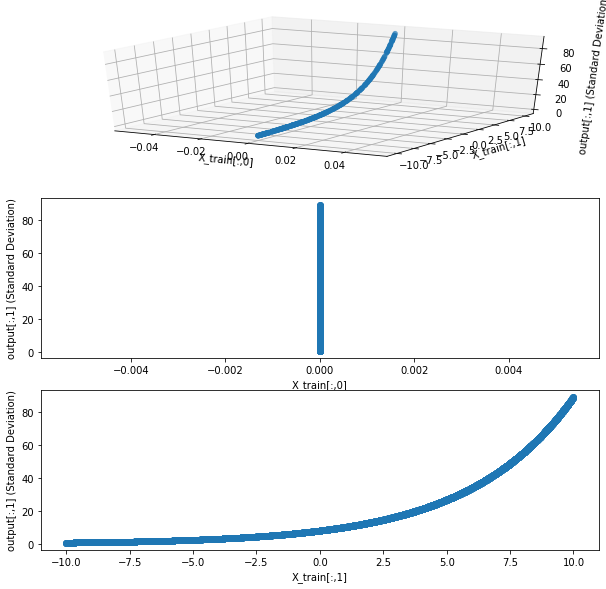

In [0]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

final_pred = bnn.model.forward(torch.Tensor(X_train))
print(final_pred[:5,0])


pred_std = torch.exp(final_pred[:,1])

print(pred_std)
print(X_train)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(311, projection='3d')

sparse_cap = int(len(X_train) / 10)

ax.scatter(X_train[:sparse_cap,0], X_train[:sparse_cap,1], pred_std[:sparse_cap].detach().numpy())
ax.set_xlabel('X_train[:,0]')
ax.set_ylabel('X_train[:,1]')
ax.set_zlabel('output[:,1] (Standard Deviation)')



# 2D Plot:
ax_2d_x = fig.add_subplot(312)
ax_2d_x.scatter(X_train[:,0], pred_std.detach().numpy())
ax_2d_x.set_xlabel('X_train[:,0]')
ax_2d_x.set_ylabel('output[:,1] (Standard Deviation)')


ax_2d_y = fig.add_subplot(313)
ax_2d_y.scatter(X_train[:,1], pred_std.detach().numpy())
ax_2d_y.set_xlabel('X_train[:,1]')
ax_2d_y.set_ylabel('output[:,1] (Standard Deviation)')



[ 0.7019849  0.8952522  1.1417292  1.4560653  1.8569429  2.3681886
  3.020188   3.8516934  4.9121256  6.2645106  7.9892287 10.18879
 12.993922  16.571356  21.13371   26.95215   34.372505  43.8358
 55.904476  71.295845  90.9247   ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


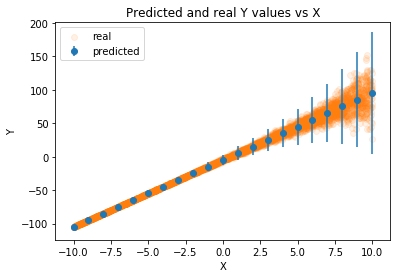

[array([0.05502322]), array([0.07427358]), array([0.10025884]), array([0.13533528]), array([0.18268352]), array([0.24659696]), array([0.33287108]), array([0.44932896]), array([0.60653066]), array([0.81873075]), array([1.10517092]), array([1.4918247]), array([2.01375271]), array([2.71828183]), array([3.66929667]), array([4.95303242]), array([6.68589444]), array([9.0250135]), array([12.18249396]), array([16.44464677]), array([22.19795128])]


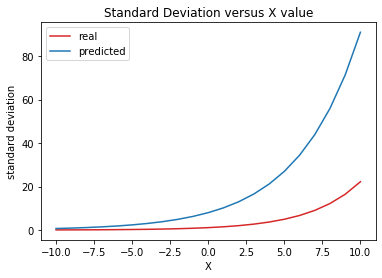

In [0]:
np.zeros(40)
X_sample = np.vstack([np.zeros(21), np.array(list(range(-10,11)))]).T
X_sample = torch.tensor(np.array(X_sample), dtype=torch.float32)


predictions = bnn.model.forward(torch.Tensor(X_train))

sample_pred = bnn.model.forward(X_sample)

y_pred = sample_pred[:,0].detach().numpy()
std_pred = torch.exp(sample_pred[:,1]).detach().numpy()
log_s_pred = sample_pred[:,1].detach().numpy()

print(std_pred)

# Sample variance to add to the y predictions
std_array = []
for scale in std_pred:
  std_array.append(np.random.normal(loc=0, scale=np.exp(scale)))
std_array = np.array((std_array))



"""
plt.scatter(X_train[:,0], y_pred + std_array, alpha=.1, label='predicted')
plt.scatter(X_train[:,0], y_train, alpha=.1, label='real')
plt.title("Y hat and Y values across X1")
plt.legend()
plt.savefig("x1_y.png")
"""


plt.show()

# For constant std dev#
#std_pred = 10 * torch.ones([y_pred.shape[0]], dtype=torch.float64)
# For constant std dev#

#plt.scatter(X_train[:,1], y_pred + std_array, alpha=.1, label='predicted')
#plt.scatter(X_sample[:,1], y_pred, alpha=.1, label='predicted')
plt.errorbar(X_sample[:,1], y_pred, yerr=(std_pred), fmt='o', label='predicted')
plt.scatter(X_train[:,1], y_train, alpha=.1, c='C1', label='real')
plt.ylabel("Y")
plt.xlabel("X")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.title("Predicted and real Y values vs X")
plt.legend()
plt.savefig("x_y1.png")
plt.show()



#stds = []
#Xs = list(range(-10, 11))
#for x in Xs:
#    stds.append(x + b_s)

#std_pred = predictions[:,1].detach().numpy()

real_std = []
for x in range(-10, 11):
    real_std.append(np.exp(np.array([0, x] @ W_s + b_s)))
print(real_std)
# plt.plot(list(range(-10,11)), list(range(0, 21)), c='C3', label='real')
plt.plot(list(range(-10,11)), real_std, c='C3', label='real')
plt.plot(X_sample[:,1], (std_pred), label='predicted')
plt.title("Standard Deviation versus X value")
plt.ylabel("standard deviation")
plt.xlabel("X")
plt.legend()
plt.savefig("std1.png")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.show()

In [0]:
print(torch.exp(bnn.model.l1.W_log_s_DO))

tensor([[0.1449, 0.1307, 0.1374, 0.1398, 0.1270],
        [0.5950, 0.5896, 0.5357, 0.6016, 0.5273]], grad_fn=<ExpBackward>)


In [0]:

plt.plot([i for i in range(100)], loss_by_epoch)

NameError: ignored